In [146]:
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw

import math

import numpy as np
from numpy.linalg import norm
from math import acos

import json

In [4]:
def draw_image(strokes_list):
    im = Image.new(mode="1", size=(500,500))

    draw = ImageDraw.Draw(im)
    #draw.moveTo(strokes[0][:2], fill=128)
    #print(strokes)
    #draw.line((0, 0) + im.size, fill=128)
    #draw.line((0, im.size[1], im.size[0], 0), fill=128)
    for strokes in strokes_list:
        draw.line(strokes, fill=128, width=5)
    
    
    #for stroke in strokes[0:]:
        #print(stroke.tolist())
        #draw.line(stroke, fill=128, width=10)

    plt.imshow(im)

In [23]:
def angle(x, y, z):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    w = z - y
    v = y - x
    #fix_domain()
    return acos(min(max(v.dot(w)/(norm(v) * norm(w)), -1),1))

#dominant :: Double -> Stroke -> Stroke
#dominant alpha s@(x:y:z:ps) = x:(dominant' alpha s) where
#  dominant' alpha (x:y:z:ps) | angle x y z < alpha = dominant' alpha (x:z:ps)
#                             | otherwise = y:(dominant' alpha (y:z:ps))
#  dominant' _ (x:ps) = ps
#  
#  
#  -- angle x y z = acos (min 1 (max (-1) (1/((norm v)*(norm w)) `scalar` v `dot` w))) where
#  angle x y z = acos $ fixdomain $ (v `dot` w)/((norm v)*(norm w)) where
#    fixdomain = (min 1).(max (-1))
#    v = y `sub` x
#    w = z `sub` y
    
    
#dominant _ ps = ps
def dominant(alpha, strokes):
    
    if len(strokes) < 3:
        return strokes
    
    return [strokes[0]] + dominant_(alpha, strokes)

#dominant' alpha (x:y:z:ps) | angle x y z < alpha = dominant' alpha (x:z:ps)
#                           | otherwise = y:(dominant' alpha (y:z:ps))
#dominant' _ (x:ps) = ps
def dominant_(alpha, strokes):
    if len(strokes) < 3:
        return strokes[1:]
    
    x = strokes[0]
    y = strokes[1]
    z = strokes[2]
    ps = strokes[3:]
    
    #If the angle between the links are too small, the middle point is kind of irrelevant, we may remove it
    if angle(x,y,z) < alpha:
        return dominant_(alpha, [x] + [z] + ps)
    
    return [y] + dominant_(alpha, [y] + [z] + ps)

In [25]:
#-- remove successive duplicate (similar) points
#unduplicate :: Stroke -> Stroke
#unduplicate [] = []
#unduplicate [p] = [p]
#unduplicate (p:q:ps) | p ~~ q    = unduplicate (p:ps)
#                     | otherwise = p:(unduplicate (q:ps))

def unduplicate(strokes):
    if len(strokes) < 2:
        return strokes
    
    if strokes[0] == strokes[1]:
        return unduplicate(strokes[1:])
    else:
        return strokes[0:1] + unduplicate(strokes[1:])
    
test_strokes = [
    [200,200],
    [200,400],
    [400,800]
]

unduplicate(test_strokes)

[[200, 200], [200, 400], [400, 800]]

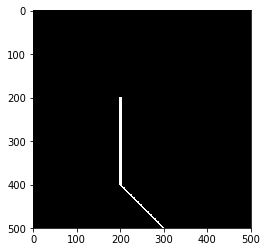

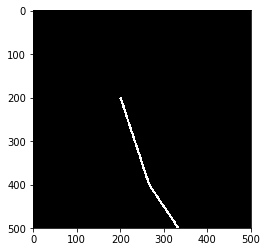

In [26]:
#-- smooth
#smooth :: Stroke -> Stroke
#smooth s@(x:y:z:ps) = x:(smooth' s) where
#  smooth' (x:y:z:ps) = ((1/3) `scalar` (x `add` y `add` z)):(smooth' (y:z:ps))
#  smooth' (x:ps) = ps
#smooth ps = ps

def smooth(strokes):
    return [strokes[0]] + smooth_(strokes)

def smooth_(strokes):
    if len(strokes) < 3:
        return strokes[1:]
    
    x = np.array(strokes[0])
    y = np.array(strokes[1])
    z = np.array(strokes[2])
    
    w = (x+y+z)/3
    
    return [tuple(w)] + smooth_(strokes[1:])

test_strokes = [
    (200,200),
    (200,400),
    (400,600),
]

draw_image([test_strokes])
plt.show()
draw_image([smooth(test_strokes)])
plt.show()

In [27]:
#-- redistribute to equidistant series by number of points
#-- this might go wrong due to numeric inaccuracy (esp. for large n)
#-- but together with unduplicate it should work well enough
#redistribute :: Int -> Stroke -> Stroke
#-- degenerate cases
#redistribute _ [] = []
#redistribute _ [p] = [p]
#-- normal cases
#redistribute 0 _ = []
#redistribute 1 s = [head s]
#redistribute num stroke@(p:q:ps) = redistribute' dist stroke where
#  dist = (slength stroke) / ((fromIntegral num) - 1)

def redistribute(num, stroke):
    if num == 0:
        return []
    if num == 1:
        return [stroke[0]]
    
    dist_value = slength(stroke) / (num - 1)
    
    return redistribute_(dist_value, stroke)

#-- redistribute to equidistant series by distance
#redistribute' :: Double -> Stroke -> Stroke
#redistribute' dist _ | dist <= 0 = error "No Sir! No redistribution with non-positive distance!"
#redistribute' dist s@(p:q:ps) = p:(redist dist s) where -- first point always part of new stroke

#  redist :: Double -> Stroke -> Stroke
#  redist left (p:q:ps) | d < left = redist (left - d) (q:ps)
#                       | otherwise = ins:(redist dist (ins:q:ps))
#                         where
#                           dir = q `sub` p
#                           d = norm dir
#                           ins = p `add` ((left/d) `scalar` dir)
#  redist _ ps = ps -- done when only one left
#redistribute' _ ps = ps -- empty or single point strokes stay unmodified
def redistribute_(dist_value, stroke):
    
    def redist(left, stroke):
        if len(stroke) < 2:
            return stroke
        
        p = np.array(stroke[0])
        q = np.array(stroke[1])

        dir_ = q - p
        d = norm(dir_)


        if d < left:
            return redist((left-d), stroke[1:])
        else:
            ins = p + ((left/d) * dir_)
            return [tuple(ins)] + redist(dist_value, [ins] + stroke[1:])
        
    assert dist_value > 0
    
    if len(stroke) < 2:
        return stroke
    
    return [stroke[0]] + redist(dist_value, stroke)
        
redistribute(3, test_strokes)

[(200, 200),
 (229.28932188134524, 429.28932188134524),
 (400.0, 600.0),
 (400, 600)]

In [193]:
#slength :: Stroke -> Double
#slength (p:q:ps) = p `dist` q + (slength (q:ps))
#slength _ = 0

def slength(strokes):
    if len(strokes) < 2:
        return 0
    
    return dist(strokes[0], strokes[1]) + slength(strokes[1:])

def dist(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return norm(v1-v2)

slength(test_strokes)

670.8203932499368

In [59]:
def bounding_box(stroke):
    min_x = math.inf
    min_y = math.inf
    max_x = -math.inf
    max_y = -math.inf
    for x, y in stroke:
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x)
        max_y = max(max_y, y)
        
    return [(min_x, min_y), (max_x, max_y)]

bounding_box(dataset[100][0])

[(112, 86.1333312988281), (281, 258.133331298828)]

In [60]:
#aspectrefit :: Rect -> Stroke -> Stroke
#aspectrefit r s = refit (aspectfit (boundingbox s) r) s

def aspect_refit(r, s):
    return refit(aspect_fit(bounding_box(s), r), s)

[(100, 200), (200, 400), (400, 800)]


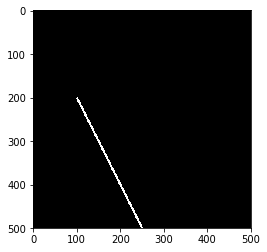

[(0.0, 0.0), (66.66666666666666, 66.66666666666666), (200.0, 200.0)]


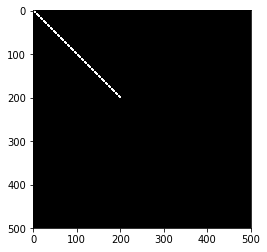

In [132]:
#-- fit into rect (x1, y1, x2, y2)
#refit :: Rect -> Stroke -> Stroke
#refit (Point (x1, y1), Point (x2, y2)) _ | x1 > x2 || y1 > y2 = error "Dude! Your rect doesn't make sense!"
#refit _ [] = [] 
#refit (Point (x1, y1), Point (x2, y2)) stroke = for stroke $ \p -> (scale scaleX scaleY (p `sub` reset)) `add` trans
#  where
#    (Point (bbx1, bby1), Point (bbx2, bby2)) = boundingbox stroke
#    reset = Point (bbx1, bby1)
#    bbWidth = bbx2 - bbx1
#    bbHeight = bby2 - bby1
#    targetWidth = x2 - x1
#    targetHeight = y2 - y1
#    scaleX = case bbWidth of
#      0 -> 1
#      width -> 1/width * targetWidth
#    scaleY = case bbHeight of
#      0 -> 1
#      height -> 1/height * targetHeight
#    transX = case bbWidth of
#      0 -> x1 + 1/2 * targetWidth
#      width -> x1
#    transY = case bbHeight of
#      0 -> y1 + 1/2 * targetHeight
#      height -> y1
#    trans = Point (transX, transY)

def refit(r, stroke):
    if len(stroke) == 0:
        return stroke
    
    (x1, y1), (x2, y2) = r
    assert x1 <= x2 and y1 <= y2, "Coords x1: {}, x2: {}, y1: {}, y2: {}".format(x1, x2, y1, y2)
    
    (bbx1, bby1), (bbx2, bby2) = bounding_box(stroke)
    reset = np.array((bbx1, bby1))
    
    bbWidth = bbx2 - bbx1
    bbHeight = bby2 - bby1
    targetWidth = x2 - x1
    targetHeight = y2 - y1
    
#    scaleX = case bbWidth of
#      0 -> 1
#      width -> 1/width * targetWidth
    scaleX = 1 if bbWidth == 0 else targetWidth/bbWidth

#    scaleY = case bbHeight of
#      0 -> 1
#      height -> 1/height * targetHeight
    scaleY = 1 if bbHeight == 0 else targetHeight/bbHeight

#    transX = case bbWidth of
#      0 -> x1 + 1/2 * targetWidth
#      width -> x1
    transX = x1 + 0.5 * targetWidth if bbWidth == 0 else x1

#    transY = case bbHeight of
#      0 -> y1 + 1/2 * targetHeight
#      height -> y1
    transY = y1 + 0.5 * targetHeight if bbHeight == 0 else y1

    trans = np.array((transX, transY))
    
#refit (Point (x1, y1), Point (x2, y2)) stroke = for stroke $ \p -> (scale scaleX scaleY (p `sub` reset)) `add` trans
    refit_strokes = list()
    
    scale_mat = np.array([
        [scaleX, 0],
        [0, scaleY]
    ])
    
    for p in stroke:
        p = np.array(p)
        t_p = scale_mat.dot(p - reset) + trans
        refit_strokes.append(tuple(t_p))
        
    return refit_strokes

refit_strokes = refit([(0,0), (200,200)], test_strokes)

print(test_strokes)
draw_image([test_strokes])
plt.show()

print(refit_strokes)
draw_image([refit_strokes])
plt.show()


In [133]:
#-- fit the first rect maximally and centered into the second rect keeping the aspect ratio
#aspectfit :: Rect -> Rect -> Rect
#aspectfit source@(a, b) target@(c, d) | a == b = ((1/2) `scalar` (c `add` d), (1/2) `scalar` (c `add` d))
#                                      | otherwise = both reposition source where
#  reset = fst source
#  sourcewidth = width source
#  sourceheight = height source
#  targetwidth = width target
#  targetheight = height target
#  sourceratio = sourcewidth/sourceheight
#  targetratio = targetwidth/targetheight
#  -- bigger ratio <~> wider
#  sourcewider = sourceratio > targetratio
#  scalefactor | sourcewider = 1/sourcewidth*targetwidth -- scale to fit width of target and center
#              | otherwise   = 1/sourceheight*targetheight
#  offset      | sourcewider = Point (0, (targetheight - scalefactor*sourceheight)/2)
#              | otherwise   = Point ((targetwidth - scalefactor*sourcewidth)/2, 0)
#  reposition p = (scale scalefactor scalefactor (p `sub` reset)) `add` offset `add` (fst target)

def both(f, l):
    a,b = l
    return (f(a), f(b))

def aspect_fit(source, target):
    a, b = np.array(source)
    c, d = np.array(target)
    
    if np.array_equal(a,b):
        return 0.5*(c+d), 0.5*(c+d)
    else:
        def reposition(p):
            p = np.array(p)
            
            reset = source[0]
            sourcewidth = source[1][0] - source[0][0]
            sourceheight = source[1][1] - source[0][1]
            targetwidth = target[1][0] - target[0][0]
            targetheight = target[1][1] - target[0][1]
            sourceratio = sourcewidth/sourceheight
            targetratio = targetwidth/targetheight
            
            sourcewider = sourceratio > targetratio
            
            if sourcewider:
                scalefactor = targetwidth/sourcewidth #scale to fit width of target and center
                offset = (0, (targetheight - scalefactor*sourceheight)/2)
            else:
                scalefactor = targetheight/sourceheight
                offset = ((targetwidth - scalefactor*sourcewidth)/2, 0)
            
            offset = np.array(offset)
            
            return scalefactor * (p-reset) + offset + target[0]
        
        
        return both(reposition, source)
        

In [134]:
dataset = pickle.load( open( "save.p", "rb" ) )

In [135]:
list(map(lambda a: print(len(a)), dataset[1]))
print("")
reduced = list(map(lambda a: dominant(0.5,a), dataset[1]))
list(map(lambda a: print(len(a)), reduced))

347
91
116

181
63
21


[None, None, None]

In [136]:
list(map(smooth, dataset[1]))

[[(190.5, 100.133331298828),
  (189.16666666666666, 99.46666463216137),
  (187.83333333333334, 98.79999796549471),
  (186.5, 97.46666463216143),
  (184.5, 96.79999796549475),
  (182.5, 96.13333129882808),
  (180.5, 96.13333129882808),
  (178.5, 96.13333129882808),
  (177.16666666666666, 95.46666463216143),
  (175.83333333333334, 94.79999796549475),
  (174.5, 94.13333129882808),
  (172.5, 94.13333129882808),
  (171.16666666666666, 93.46666463216143),
  (169.83333333333334, 92.79999796549475),
  (168.5, 92.13333129882808),
  (166.5, 92.13333129882808),
  (164.5, 92.13333129882808),
  (162.5, 92.79999796549475),
  (159.83333333333334, 93.46666463216143),
  (157.16666666666666, 94.13333129882808),
  (154.5, 94.13333129882808),
  (153.16666666666666, 94.79999796549475),
  (151.16666666666666, 95.46666463216143),
  (149.16666666666666, 96.79999796549475),
  (147.16666666666666, 98.13333129882807),
  (145.83333333333334, 100.13333129882803),
  (144.5, 101.46666463216133),
  (143.1666666666666

0.2617993877991494


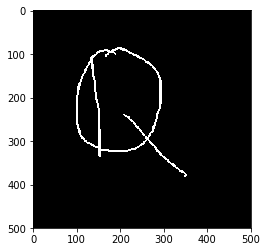

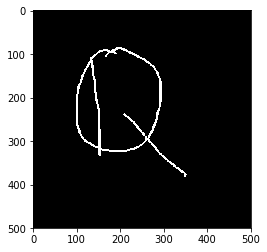

In [137]:
alpha = 2*math.pi*15/360
print(alpha)

draw_image(dataset[1])
plt.show()
#draw_image(list(map(lambda a: dominant(alpha,a), dataset[1])))
draw_image(list(map(smooth, dataset[1])))
plt.show()

In [237]:
alpha = 2*math.pi*15/360

#sanitize = (map (dominant alpha
#                .unduplicate
#                .redistribute 10
#                .aspectrefit (Point (0,0), Point (1,1))
#                .smooth
#                .unduplicate)
#                ).limit 10"""

def process_stroke(stroke, scale=1):
    t_stroke = stroke
    t_stroke = unduplicate(stroke)
    t_stroke = smooth(t_stroke)
    t_stroke = aspect_refit(((0,0), (scale,scale)), t_stroke)
    t_stroke = redistribute(10, t_stroke)
    t_stroke = unduplicate(t_stroke)
    t_stroke = dominant(alpha, t_stroke)
    return t_stroke

def process(strokes, scale=1):
    return list(map(lambda a: process_stroke(a, scale), strokes[:10])) 

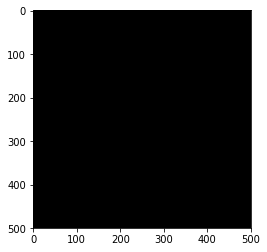

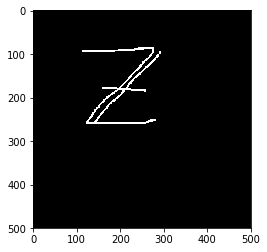

In [150]:
ind = 100

draw_image(process(dataset[ind]))
plt.show()
draw_image(dataset[ind])
plt.show()

## Test Classification

In [147]:
snapshot = json.loads(open(r"C:\Users\du0x\Desktop\detexify\detexify-hs-backend\snapshot.json").read())

In [228]:
def arr_from_dict(d, scale=1):
    arr = list()
    
    for s in d:
        s_arr = list()
        for dict_data in s:
           s_arr.append((dict_data['x']*scale, dict_data['y']*scale))
        arr.append(s_arr)
    return arr

In [192]:
#a = arr_from_dict(list(snapshot.values())[0][0]['strokes'])
#b = arr_from_dict(list(snapshot.values())[0][0]['strokes'])
#dist, _ = fastdtw(a[0], b[0], dist=manhattan)
#dist

In [217]:
#snapshot.keys()

In [218]:
#symbols

In [219]:
#snapshot['YW1zc3ltYi1PVDEtX2dn']

In [206]:
#classifyWithClassifier :: Sample s => Classifier s -> s -> IO Results
#classifyWithClassifier c@(Classifier k t) unknown = do
#  samples <- getSamples c
#  return $ (sort . toScores . Hash.toList . Hash.map mindist) samples where
#    toScores = map (\(id, score) -> Score id score)
#    mindist = (meanmin 2) . (map (\next -> distance unknown next))
#    meanmin n unsorted = mean (take n sorted) where
#      sorted = sort unsorted
#      mean = (\(a,b) -> (a/b)) . (foldl (\(a,b) c -> (a+c,b+1)) (0,0))

from collections import Counter

snapshot_size = len(snapshot)

def classifyWithClassifier(strokes):
    scores = Counter()
    strokes = process(strokes)
    
    concat_strokes = concat_list(strokes)
    
    for i, (id_value, samples) in enumerate(snapshot.items()):
        print("\r{}/{}".format(i+1, snapshot_size), end="")
        
        distance_values = list()
        
        for sample in samples:
            sample = arr_from_dict(sample['strokes'])
            concat_sample = concat_list(sample)
            distance_value = strokes_distance(concat_strokes, concat_sample)
            distance_values.append(distance_value)
            
        distance_values = sorted(distance_values)
        mean_min = sum(distance_values[:2])/2

        scores[id_value] = mean_min

    return scores

def concat_list(a):
    concat_a = list()
    for d in a:
        concat_a += d
    return concat_a

def strokes_distance(a, b):
    distance, path = fastdtw(a, b, dist=manhattan)
    
    return distance    

scores_values = classifyWithClassifier(dataset[100])

1072/1072

In [205]:
symbols = json.loads(open(r"C:\Users\du0x\Documents\Projetos\mathwhat\dataset\detexify data\symbols.json").read())

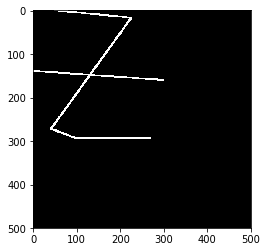

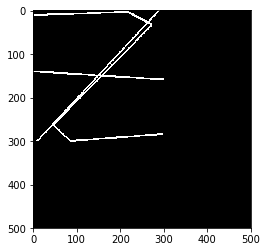

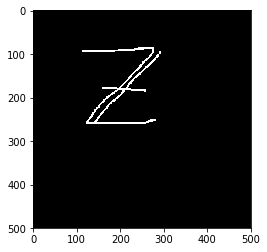

In [240]:
draw_image(arr_from_dict(snapshot['YW1zc3ltYi1PVDEtX21hdGhjYWx7Wn0='][10]['strokes'], 300))
plt.show()
draw_image(process(dataset[100], 300))
plt.show()
draw_image(dataset[100])
plt.show()

In [222]:
scores_values.most_common()[-1]

('YW1zc3ltYi1PVDEtX21hdGhjYWx7Wn0=', 2.2419689202041417)

In [207]:
symbols

[{'command': '\\textasciicircum',
  'css_class': 'symbol0fc0a6460b919255cae7741740fcfcdb',
  'id': 'latex2e-OT1-_textasciicircum',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textless',
  'css_class': 'symbol8d5aed0bf13f89286d7d600bd3b6f998',
  'id': 'latex2e-OT1-_textless',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textasciitilde',
  'css_class': 'symbol46c29390c9cf916a34a9748ecb44b59e',
  'id': 'latex2e-OT1-_textasciitilde',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textordfeminine',
  'css_class': 'symbol9622c859e6bcde47476d601346929164',
  'id': 'latex2e-OT1-_textordfeminine',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textasteriskcentered',
  'css_class': 'symbol64973858a2e540a38ac594805ae83cd8',
  'id': 'latex2e-OT1-_textasteriskcentered',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textordmasculine',
  'css_class': 'symbol970176e9a7af129519e6cbda104b6937',
  'id': 'latex2e-OT1-_textordmasculine',
  'mathm

In [172]:
import numpy as np
from scipy.spatial.distance import euclidean, cityblock
manhattan = cityblock

from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=manhattan)
print(distance)

4.0


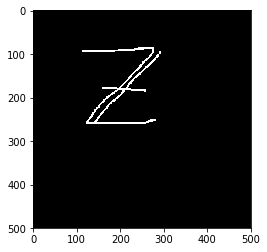

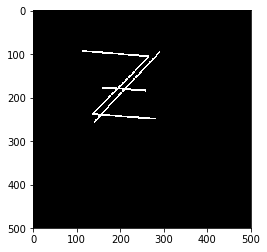

In [37]:
draw_image(dataset[100])
plt.show()
draw_image(list(map(lambda a: redistribute(4,a), dataset[100])))
plt.show()

In [18]:
#vendomorphism :: ((Double, Double), (Double, Double)) -> Point -> Point
#vendomorphism ((a11, a12), (a21, a22)) (Point (x, y)) = Point (a11*x + a12*y, a21*x + a22*y)
#def vendomorphism(a, p):
    #(a11, a12), (a21, a22) = a
    #x, y = p
    #return (a11*x + a12*y, a21*x + a22*y)

#scale :: Double -> Double -> Point -> Point
#scale x y = vendomorphism ((x, 0), (0, y))
#def scale(x, y):
    #return vendomorphism ((x, 0), (0, y))

In [74]:
test_strokes = [
    (100,200),
    (200,400),
    (400,800)
]

dominant(0.4, test_strokes)

[(100, 200), (400, 800)]

In [20]:
x = np.array([0,0])
y = np.array([2,2])
z = np.array([4,8])

angle(x,y,z)

0.46364760900080615

In [39]:
2*math.pi*15/360

0.2617993877991494